# Dataset CIFAR10

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


          plane             cat             car             cat             cat             car           truck            deer


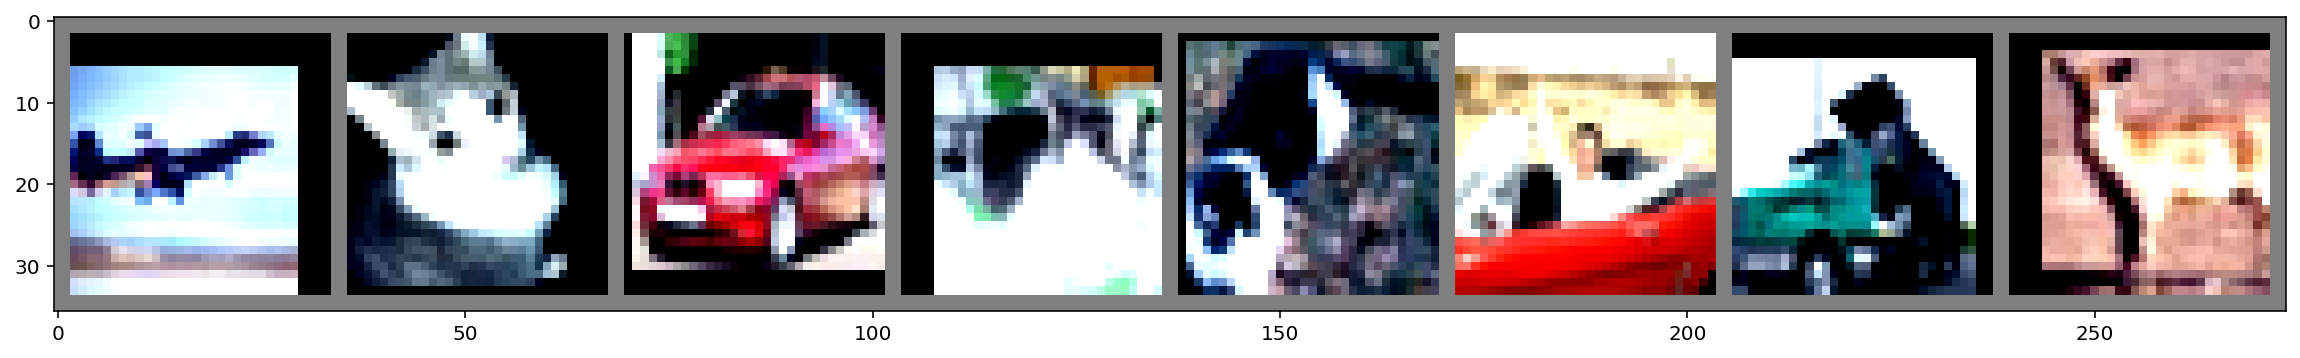

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=128, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
plt.figure(figsize=(20,10)) 

# show images
imshow(torchvision.utils.make_grid(images[0:8,:,:]))
# print labels
print(' '.join('%15s' % classes[labels[j]] for j in range(8)))


# ResNet20 Architecture

In [ ]:
import torch.nn as nn


def conv3x3(in_channels, out_channels, stride=1):
    
    # return 3x3 Conv2d

    return nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=stride, padding=1, bias=False)


class ResidualBlock(nn.Module):

    # Initialize basic ResidualBlock with forward propogation

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    
    # Initialize  ResNet with forward propogation

    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Accuracy function

In [ ]:
class AverageMeter(object):

    #Computes and stores the average and current value

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):

    #Computes the accuracy
    
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

# Training loop

In [ ]:
import time

def train(train_loader, model, criterion, optimizer, epoch):
    
    # Run one train epoch

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    model.train()

    end = time.time()

    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        input_var = input.cuda()
        target_var = target

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 55 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))

# Validation loop

In [ ]:
def validate(val_loader, model, criterion):
    
    # Run evaluation
  
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):

            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()


    print('Test\t  Prec@1: {top1.avg:.3f} (Err: {error:.3f} )\n'
          .format(top1=top1,error=100-top1.avg))

    return top1.avg

# Training

In [ ]:
import os

model = ResNet(ResidualBlock, [3, 3, 3])
model.cuda()

# define loss function and pptimizer
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), 0.1,
                                momentum=0.9,
                                weight_decay=1e-4)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], last_epoch=0 - 1)

for epoch in range(0, 200):

  # train for one epoch

  print('Training resnet20 model')
  print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
  train(train_loader, model, criterion, optimizer, epoch)
  lr_scheduler.step()

  # evaluate on validation set
  prec1 = validate(val_loader, model, criterion)

Training resnet20 model
current lr 1.00000e-01


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0][0/391]	Loss 2.3094 (2.3094)	Prec@1 10.938 (10.938)
Epoch: [0][55/391]	Loss 1.8240 (2.0695)	Prec@1 26.562 (22.238)
Epoch: [0][110/391]	Loss 1.8549 (1.9614)	Prec@1 39.062 (25.612)
Epoch: [0][165/391]	Loss 1.6789 (1.9017)	Prec@1 34.375 (27.923)
Epoch: [0][220/391]	Loss 1.4253 (1.8494)	Prec@1 48.438 (29.931)
Epoch: [0][275/391]	Loss 1.5943 (1.8005)	Prec@1 46.094 (32.088)
Epoch: [0][330/391]	Loss 1.4946 (1.7613)	Prec@1 43.750 (33.691)
Epoch: [0][385/391]	Loss 1.5170 (1.7190)	Prec@1 41.406 (35.304)
Test	  Prec@1: 44.320 (Err: 55.680 )

Training resnet20 model
current lr 1.00000e-01
Epoch: [1][0/391]	Loss 1.3306 (1.3306)	Prec@1 50.781 (50.781)
Epoch: [1][55/391]	Loss 1.3508 (1.3631)	Prec@1 50.000 (50.321)
Epoch: [1][110/391]	Loss 1.4697 (1.3276)	Prec@1 45.312 (51.858)
Epoch: [1][165/391]	Loss 1.2923 (1.2939)	Prec@1 50.000 (53.389)
Epoch: [1][220/391]	Loss 1.3838 (1.2671)	Prec@1 49.219 (54.550)
Epoch: [1][275/391]	Loss 1.0213 (1.2389)	Prec@1 58.594 (55.511)
Epoch: [1][330/391]	Loss 

# Save model

In [ ]:
torch.save(model.state_dict(), '/content/net2.pth')

# Check the model

In [ ]:
model = ResNet(ResidualBlock, [3, 3, 3])
model.cuda()
criterion = nn.CrossEntropyLoss()
model.load_state_dict(torch.load('/content/net2.pth'))
model.eval()
validate(val_loader, model, criterion)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test	  Prec@1: 92.110 (Err: 7.890 )



92.11

Получилось добиться точности в 92.11%

# Quantized Resnet20

In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    
    # return 3x3 Conv2d
   
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=stride, padding=1, bias=False)


class QuantizedResidualBlock(nn.Module):
    
    # Initialize basic QuantizedResidualBlock with forward propogation
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None,quantized=True):
        super(QuantizedResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.quantized = quantized
        self.skip_add = nn.quantized.FloatFunctional()
        
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        if self.quantized:
            out = self.skip_add.add(out, residual)
        else:
            out += residual  
        out = self.relu(out)
        return out


class QuantizedResNet(nn.Module):
    
    # Initialize  ResNet with forward propogation
    
    def __init__(self, block, layers, num_classes=10):
        super(QuantizedResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

        # QuantStub converts tensors from floating point to quantized
        self.quant = torch.quantization.QuantStub()
        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.quantization.DeQuantStub()
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):

        # tensors will be converted from floating point to quantized
        out = self.quant(x)

        out = self.conv(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        # tensors will be converted from quantized to floating point
        out = self.dequant(out)
        
        return out

# Let's look at the model

In [ ]:
model = ResNet(ResidualBlock, [3, 3, 3]).to('cuda')
model.load_state_dict(torch.load('/content/net2.pth'))
model.eval()

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

# Let's look at the quantized model

In [ ]:
model_quantized = QuantizedResNet(QuantizedResidualBlock, [3, 3, 3]).to('cpu')
model_quantized.load_state_dict(torch.load('/content/net2.pth'))
model_quantized.eval()

QuantizedResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): QuantizedResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
      (quant): QuantStub()
      (dequant): DeQuantStub()
    )
    (1): QuantizedResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05

# Post Training Static Quantization

In [ ]:
#Layers to fuse
modules_to_fuse = [['conv', 'bn'],
                   ['layer1.0.conv1', 'layer1.0.bn1'],
                   ['layer1.0.conv2', 'layer1.0.bn2'],
                   ['layer1.1.conv1', 'layer1.1.bn1'],
                   ['layer1.1.conv2', 'layer1.1.bn2'],
                   ['layer1.2.conv1', 'layer1.2.bn1'],
                   ['layer1.2.conv2', 'layer1.2.bn2'],
                   
                   ['layer2.0.conv1', 'layer2.0.bn1'],
                   ['layer2.0.conv2', 'layer2.0.bn2'],
                   ['layer2.0.downsample.0', 'layer2.0.downsample.1'],
                   ['layer2.1.conv1', 'layer2.1.bn1'],
                   ['layer2.1.conv2', 'layer2.1.bn2'],
                   ['layer2.2.conv1', 'layer2.2.bn1'],
                   ['layer2.2.conv2', 'layer2.2.bn2'],
                   
                   ['layer3.0.conv1', 'layer3.0.bn1'],
                   ['layer3.0.conv2', 'layer3.0.bn2'],
                   ['layer3.0.downsample.0', 'layer3.0.downsample.1'],
                   ['layer3.1.conv1', 'layer3.1.bn1'],
                   ['layer3.1.conv2', 'layer3.1.bn2'],
                   ['layer3.2.conv1', 'layer3.2.bn1'],
                   ['layer3.2.conv2', 'layer3.2.bn2']]

# Fusing layers
model_quantized = torch.quantization.fuse_modules(model_quantized, modules_to_fuse)
# attach a global qconfig, which contains information about what kind of observers to attach
model_quantized.qconfig = torch.quantization.get_default_qconfig('fbgemm')
# This inserts observers in the model that will observe activation tensors during calibration.
torch.quantization.prepare(model_quantized, inplace=True)
model_quantized.eval();

for i, (images, labels) in enumerate(train_loader):
    images = images.to('cpu')
    model_quantized(images)
# Finally, convert the observed model to a quantized model
torch.quantization.convert(model_quantized, inplace=True)

/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:178: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:1137: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  Returning 

QuantizedResNet(
  (conv): QuantizedConv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.08240721374750137, zero_point=56, padding=(1, 1))
  (bn): Identity()
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): QuantizedResidualBlock(
      (conv1): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.09511621296405792, zero_point=63, padding=(1, 1))
      (bn1): Identity()
      (relu): ReLU(inplace=True)
      (conv2): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.08836288005113602, zero_point=69, padding=(1, 1))
      (bn2): Identity()
      (skip_add): QFunctional(
        scale=0.11665356159210205, zero_point=52
        (activation_post_process): Identity()
      )
      (quant): Quantize(scale=tensor([1.]), zero_point=tensor([0]), dtype=torch.quint8)
      (dequant): DeQuantize()
    )
    (1): QuantizedResidualBlock(
      (conv1): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.08194230496883392, zero_point=58, 

# Function to test accuracy

In [ ]:
def test(val_loader, model, criterion):
    
    # Run evaluation
    
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.to('cpu')
            input_var = input.to('cpu')
            target_var = target.to('cpu')

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()


    print('Test\t  Prec@1: {top1.avg:.3f} (Err: {error:.3f} )\n'
          .format(top1=top1,error=100-top1.avg))

    return top1.avg

# Check the quantized model

In [ ]:
criterion = nn.CrossEntropyLoss()
#model_quantized.eval()
test(val_loader, model_quantized, criterion)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test	  Prec@1: 91.820 (Err: 8.180 )



91.82

Точность сжатой модели 91.82%. Это чуть хуже чем точность исходной модели (92.11%), но даже не смотря на это это высокая точность.

# Print size of the model

In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size of the model(MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [ ]:
import os
print_size_of_model(model_quantized)
print_size_of_model(model)

Size of the model(MB): 0.359661
Size of the model(MB): 1.219329


Как мы можем увидеть размер сжатой модели 3,4 раза меньше размера исходной модели. Учитывая небольшую разницу в точности, можем сказать, что метод Post training static quantization успешно реализован.

# Build own PTQ

# Quantization functions

In [ ]:
from collections import namedtuple
import torch
import torch.nn as nn

QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])

def calcScaleZeroPoint(min_val, max_val,num_bits=8):

  # Calculate Scale and zero point of next 

  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale
  
  zero_point = 0
  if initial_zero_point < qmin:
      zero_point = qmin
  elif initial_zero_point > qmax:
      zero_point = qmax
  else:
      zero_point = initial_zero_point

  zero_point = int(zero_point)

  return scale, zero_point

def quantize_tensor(x, num_bits=8, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()
    
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

In [ ]:
import torch.nn.functional as F

def quantizeLayer(x, layer, stat, scale_x, zp_x):

  # cache old values
  W = layer.weight.data
  B = layer.bias.data

  # quantise weights, activations are already quantised
  w = quantize_tensor(layer.weight.data)
  b = quantize_tensor(layer.bias.data)

  layer.weight.data = w.tensor.float()
  layer.bias.data = b.tensor.float()

  # This is Quantisation
  scale_w = w.scale
  zp_w = w.zero_point
  scale_b = b.scale
  zp_b = b.zero_point
  
  scale_next, zero_point_next = calcScaleZeroPoint(min_val=stat['min'], max_val=stat['max'])

  # Preparing input by shifting
  X = x.float() - zp_x
  layer.weight.data = scale_x * scale_w*(layer.weight.data - zp_w)
  layer.bias.data = scale_b*(layer.bias.data + zp_b)

  # All int computation
  x = (layer(X)/ scale_next) + zero_point_next 

  # Reset weights for next forward pass
  layer.weight.data = W
  layer.bias.data = B
  
  return x, scale_next, zero_point_next

## Get Max and Min stats for quantising activations of Network

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor

# Get Min and max of x tensor, and stores it
def updateStats(x, stats, key):
  max_val, _ = torch.max(x, dim=1)
  min_val, _ = torch.min(x, dim=1)
  
  
  if key not in stats:
    stats[key] = {"max": max_val.sum(), "min": min_val.sum(), "total": 1}
  else:
    stats[key]['max'] += max_val.sum().item()
    stats[key]['min'] += min_val.sum().item()
    stats[key]['total'] += 1
  
  return stats

# Reworked Forward Pass to access activation Stats through updateStats function
def gatherActivationStats(model, x, stats):

  model_hooks = create_feature_extractor(model, return_nodes = ['conv', 'bn',
                   'layer1.0.conv1', 'layer1.0.bn1',
                   'layer1.0.conv2', 'layer1.0.bn2',
                   'layer1.1.conv1', 'layer1.1.bn1',
                   'layer1.1.conv2', 'layer1.1.bn2',
                   'layer1.2.conv1', 'layer1.2.bn1',
                   'layer1.2.conv2', 'layer1.2.bn2',
                   
                   'layer2.0.conv1', 'layer2.0.bn1',
                   'layer2.0.conv2', 'layer2.0.bn2',
                   'layer2.0.downsample.0', 'layer2.0.downsample.1',
                   'layer2.1.conv1', 'layer2.1.bn1',
                   'layer2.1.conv2', 'layer2.1.bn2',
                   'layer2.2.conv1', 'layer2.2.bn1',
                   'layer2.2.conv2', 'layer2.2.bn2',
                   
                   'layer3.0.conv1', 'layer3.0.bn1',
                   'layer3.0.conv2', 'layer3.0.bn2',
                   'layer3.0.downsample.0', 'layer3.0.downsample.1',
                   'layer3.1.conv1', 'layer3.1.bn1',
                   'layer3.1.conv2', 'layer3.1.bn2',
                   'layer3.2.conv1', 'layer3.2.bn1',
                   'layer3.2.conv2', 'layer3.2.bn2'])
  
  outputs = model_hooks(x)

  for layer_name, out in outputs.items():
    stats = updateStats(out.clone().view(out.shape[0], -1), stats, layer_name)

  return stats

# Entry function to get stats of all functions.
def gatherStats(model, test_loader):
    device = 'cuda'
    
    model.eval()
    
    stats = {}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            stats = gatherActivationStats(model, data, stats)

    final_stats = {}
    for key, value in stats.items():
      final_stats[key] = { "max" : value["max"] / value["total"], "min" : value["min"] / value["total"] }
    return stats

# Forward pass for quantised model

In [ ]:
def quantForward(model, x, stats):
  
  # Quantise before inputting into incoming layers
  x = quantize_tensor(x, min_val=stats['conv']['min'], max_val=stats['conv']['max'])

  x1, scale_next, zero_point_next = quantizeLayer(x.tensor, model.conv, stats['bn'], x.scale, x.zero_point)

  x1 = F.relu(x1)

  x, scale_next, zero_point_next = quantizeLayer(x1, model.bn, stats['layer1.0.conv1'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[0].conv1, stats['layer1.0.bn1'],scale_next,zero_point_next)

  x = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[0].bn1, stats['layer1.0.conv2'],scale_next,zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[0].conv2, stats['layer1.0.bn2'],scale_next,zero_point_next)

  x += x1 
  x1 = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x1, model.layer1[0].bn2, stats['layer1.1.conv1'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[1].conv1, stats['layer1.1.bn1'],scale_next,zero_point_next)

  x = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[1].bn1, stats['layer1.1.conv2'],scale_next,zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[1].conv2, stats['layer1.1.bn2'],scale_next,zero_point_next)

  x += x1 
  x1 = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x1, model.layer1[1].bn2, stats['layer1.2.conv1'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[2].conv1, stats['layer1.2.bn1'], scale_next, zero_point_next)

  x = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[2].bn1, stats['layer1.2.conv2'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x,model.layer1[2].conv2, stats['layer1.2.bn2'], scale_next, zero_point_next)

  x += x1 
  x1 = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x1, model.layer1[2].bn2, stats['layer2.0.conv1'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[0].conv1, stats['layer2.0.bn1'], scale_next, zero_point_next)

  x = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[0].bn1, stats['layer2.0.conv2'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[0].conv2, stats['layer2.0.bn2'], scale_next, zero_point_next)

  x2, scale_next, zero_point_next = quantizeLayer(x, model.layer2[0].bn2, stats['layer2.0.downsample.0'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x1, model.layer2[0].downsample[0], stats['layer2.0.downsample.1'], scale_next, zero_point_next)

  x2 += x 
  x1 = F.relu(x2)

  x, scale_next, zero_point_next = quantizeLayer(x1, model.layer2[0].downsample[1], stats['layer2.1.conv1'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[1].conv1, stats['layer2.1.bn1'], scale_next, zero_point_next)

  x = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[1].bn1, stats['layer2.1.conv2'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[1].conv2, stats['layer2.1.bn2'], scale_next, zero_point_next)

  x += x1 
  x1 = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x1, model.layer2[1].bn2, stats['layer2.2.conv1'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[2].conv1, stats['layer2.2.bn1'], scale_next, zero_point_next)

  x = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[2].bn1, stats['layer2.2.conv2'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[2].conv2, stats['layer2.2.bn2'], scale_next, zero_point_next)

  x += x1 
  x1 = F.relu(x)###

  x, scale_next, zero_point_next = quantizeLayer(x1, model.layer2[2].bn2, stats['layer3.0.conv1'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[0].conv1, stats['layer3.0.bn1'], scale_next, zero_point_next)

  x = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[0].bn1, stats['layer3.0.conv2'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[0].conv2, stats['layer3.0.bn2'], scale_next, zero_point_next)

  x2, scale_next, zero_point_next = quantizeLayer(x, model.layer3[0].bn2, stats['layer3.0.downsample.0'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x1, model.layer3[0].downsample[0], stats['layer3.0.downsample.1'], scale_next, zero_point_next)

  x2 += x 
  x1 = F.relu(x2)

  x, scale_next, zero_point_next = quantizeLayer(x1, model.layer3[0].downsample[1], stats['layer3.1.conv1'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[1].conv1, stats['layer3.1.bn1'], scale_next, zero_point_next)

  x = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[1].bn1, stats['layer3.1.conv2'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[1].conv2, stats['layer3.1.bn2'], scale_next, zero_point_next)

  x += x1 
  x1 = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x1, model.layer3[1].bn2, stats['layer3.2.conv1'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[2].conv1, stats['layer3.2.bn1'], scale_next, zero_point_next)

  x = F.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[2].bn1, stats['layer3.2.conv2'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[2].conv2, stats['layer3.2.bn2'], scale_next, zero_point_next)

  x += x1 
  x1 = F.relu(x)

  x = model.avg_pool(x1)
  x = x.view(x.size(0), -1)

  x = dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))

  x = model.fc(x)

  return x

# Test function

In [ ]:
def testQ(val_loader, model, criterion, stats = None):
    
    # Run evaluation
    
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for input, target in val_loader:
            
            target = target.to('cuda')
            input_var = input.to('cuda')
            target_var = target.to('cuda')

            output = quantForward(model, input_var, stats)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()


    print('Test\t  Prec@1: {top1.avg:.3f} (Err: {error:.3f} )\n'
          .format(top1=top1,error=100-top1.avg))

    return top1.avg

# Get Stats

Для этого случая я обучал сеть с bias = True

In [ ]:
model = ResNet(ResidualBlock, [3, 3, 3])
model.to('cuda')
model.load_state_dict(torch.load('/content/net_bias.pth'))
stats = gatherStats(model, val_loader)
print(stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'conv': {'max': tensor(111635.2656, device='cuda:0'), 'min': tensor(-111302.9844, device='cuda:0'), 'total': 79}, 'bn': {'max': tensor(37936.5156, device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'total': 79}, 'layer1.0.conv1': {'max': tensor(63662.1211, device='cuda:0'), 'min': tensor(-99796.0625, device='cuda:0'), 'total': 79}, 'layer1.0.bn1': {'max': tensor(35085.7578, device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'total': 79}, 'layer1.0.conv2': {'max': tensor(57952.6562, device='cuda:0'), 'min': tensor(-78232.3516, device='cuda:0'), 'total': 79}, 'layer1.0.bn2': {'max': tensor(46384.4102, device='cuda:0'), 'min': tensor(-42265.9258, device='cuda:0'), 'total': 79}, 'layer1.1.conv1': {'max': tensor(95075.2031, device='cuda:0'), 'min': tensor(-161501.1875, device='cuda:0'), 'total': 79}, 'layer1.1.bn1': {'max': tensor(33537.0469, device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'total': 79}, 'layer1.1.conv2': {'max': tensor(59611.9336, device='cuda:0'), 'min': tenso

# Test quantised model

In [ ]:
criterion = nn.CrossEntropyLoss()
testQ(val_loader, model, criterion, stats=stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test	  Prec@1: 10.000 (Err: 90.000 )



10.0

In [ ]:
print_size_of_model(model)

Size of the model(MB): 1.228759


Исходя из точности и веса модели можно сказать, что не удалось в достаточной мере реализовать собственный Post training static quantization. Скорее всего я сделал в коде глупую ошибку, которую просто не замечаю. Несмотря на это, полный pipeline задания выполнил.